# Generative vs. Discriminative Models: A Comparative Analysis
Nathan Willemsen

DS552 - Generative AI | Prof. Narahara Chari Dingari, Ph.D.

January 16, 2025

---

### Assignment Overview
This assignment compares the performance of Naive Bayes (a generative model) and Logistic Regression (a discriminative model) using the Palmer Penguins dataset. We focus on binary classification between Adelie and Gentoo species, then extend our analysis to the MNIST dataset to understand how these model types perform on more complex, high-dimensional data.

#### Key Concepts
- Generative Models learn the joint distribution $P(X, Y)$ and use Bayes' theorem to compute $P(Y|X)$
- Discriminative Models directly learn the conditional distribution $P(Y|X)$

### Data Preparation

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelBinarizer, StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Load the penguins dataset
df = sns.load_dataset("penguins")

# Keep only Adelie and Gentoo species (binary classification)
df = df[df['species'].isin(['Adelie', 'Gentoo'])]

# Drop rows with missing values
df = df.dropna().reset_index(drop=True)

print(f"Dataset shape: {df.shape}")
print(f"\nClass distribution:")
print(df['species'].value_counts())
print(f"\nFeature summary:")
print(df.describe().round(2))

Dataset shape: (265, 7)

Class distribution:
species
Adelie    146
Gentoo    119
Name: count, dtype: int64

Feature summary:
       bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
count          265.00         265.00             265.00       265.00
mean            42.75          16.84             202.29      4328.68
std              5.21           2.01              15.02       839.75
min             32.10          13.10             172.00      2850.00
25%             38.60          15.00             190.00      3600.00
50%             42.00          17.00             198.00      4300.00
75%             46.80          18.50             215.00      5000.00
max             59.60          21.50             231.00      6300.00


In [2]:
# Define feature columns
feature_cols = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
categorical_cols = ['island', 'sex']

# Split into train and test sets (stratified to maintain class balance)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE, stratify=df['species'])

print(f"Training set: {len(train_df)} samples")
print(f"Test set: {len(test_df)} samples")
print(f"\nTraining class distribution:")
print(train_df['species'].value_counts())

Training set: 212 samples
Test set: 53 samples

Training class distribution:
species
Adelie    117
Gentoo     95
Name: count, dtype: int64


## Model Implementations

### Gaussian Naive Bayes (Generative Model)

Naive Bayes is a generative classifier that models the joint probability $P(X, Y)$ by assuming:

$$P(Y|X) = \frac{P(X|Y) \cdot P(Y)}{P(X)}$$

The "naive" assumption is that features are conditionally independent given the class:

$$P(X|Y) = \prod_{i=1}^{n} P(x_i|Y)$$

For continuous features, we assume Gaussian distributions:

In [3]:
# Gaussian Naive Bayes Classifier
class NaiveBayesClassifier:
    """
    Model learns:
    - Class priors P(Y)
    - Class-conditional feature distributions P(X|Y) assumed Gaussian
    """
    
    def __init__(self, var_smoothing=1e-9):
        """
        Parameters:
        -----------
        var_smoothing : float
            Portion of the largest variance added to all variances
            for numerical stability (prevents division by zero).
        """
        self.class_priors = {}  # P(Y=c)
        self.means = {}         # μ_c for each class
        self.variances = {}     # σ²_c for each class
        self.classes = None
        self.var_smoothing = var_smoothing
    
    def fit(self, X, y):
        """Learn class priors and Gaussian parameters for each feature."""
        # Convert inputs to numpy arrays
        X = np.array(X.values if hasattr(X, 'values') else X, dtype=float)
        y = np.array(y.values if hasattr(y, 'values') else y).ravel()
        
        self.classes = np.unique(y)
        n_samples = len(y)
        
        for cls in self.classes:
            X_cls = X[y == cls]
            # MLE estimates
            self.class_priors[cls] = len(X_cls) / n_samples
            self.means[cls] = np.mean(X_cls, axis=0)
            self.variances[cls] = np.var(X_cls, axis=0) + self.var_smoothing
        
        return self
    
    def _log_likelihood(self, X, cls):
        """Compute log P(X|Y=cls) assuming Gaussian features."""
        mean = self.means[cls]
        var = self.variances[cls]
        
        # Log of Gaussian PDF: -0.5 * [log(2πσ²) + (x-μ)²/σ²]
        return -0.5 * np.sum(
            np.log(2 * np.pi * var) + ((X - mean) ** 2) / var,
            axis=1
        )
    
    def predict_proba(self, X):
        """Compute posterior probabilities P(Y|X) for each class."""
        X = np.array(X.values if hasattr(X, 'values') else X, dtype=float)
        
        n_samples = X.shape[0]
        n_classes = len(self.classes)
        log_posteriors = np.zeros((n_samples, n_classes))
        
        for idx, cls in enumerate(self.classes):
            # log P(Y|X) ∝ log P(X|Y) + log P(Y)
            log_prior = np.log(self.class_priors[cls])
            log_likelihood = self._log_likelihood(X, cls)
            log_posteriors[:, idx] = log_prior + log_likelihood
        
        # Convert to probabilities via log-sum-exp trick for numerical stability
        log_posteriors -= np.max(log_posteriors, axis=1, keepdims=True)
        posteriors = np.exp(log_posteriors)
        posteriors /= np.sum(posteriors, axis=1, keepdims=True)
        
        return posteriors
    
    def predict(self, X):
        """Predict class labels for samples in X."""
        probs = self.predict_proba(X)
        return self.classes[np.argmax(probs, axis=1)]

### Logistic Regression (Discriminative Model)

Logistic Regression directly models the posterior probability $P(Y|X)$ without modeling the joint distribution. It uses the logistic (sigmoid) function:

$$P(Y=1|X) = \sigma(w^T X + b) = \frac{1}{1 + e^{-(w^T X + b)}}$$

The parameters are learned by maximizing the conditional likelihood (equivalently, minimizing cross-entropy loss).

In [4]:
# Logistic Regression Classifier (wrapper around sklearn).
class LogisticRegressionClassifier:
    """
    Discriminative model that directly learns P(Y|X)
    by optimizing the boundary between classes
    """
    
    def __init__(self, max_iter=10000, C=1.0):
        from sklearn.linear_model import LogisticRegression
        self.model = LogisticRegression(
            max_iter=max_iter,
            C=C,
            solver='lbfgs',
            random_state=RANDOM_STATE
        )
        self.classes_ = None
    
    def fit(self, X, y):
        """Fit the model by learning optimal decision boundary."""
        X = np.array(X.values if hasattr(X, 'values') else X, dtype=float)
        y = np.array(y.values if hasattr(y, 'values') else y).ravel()
        self.model.fit(X, y)
        self.classes_ = self.model.classes_
        return self
    
    def predict(self, X):
        """Predict class labels."""
        X = np.array(X.values if hasattr(X, 'values') else X, dtype=float)
        return self.model.predict(X)
    
    def predict_proba(self, X):
        """Predict class probabilities."""
        X = np.array(X.values if hasattr(X, 'values') else X, dtype=float)
        return self.model.predict_proba(X)

## 1. Accuracy Comparison

We evaluate both models on training and test datasets to compare their classification performance.

In [5]:
# Prepare features with one-hot encoding for categorical variables
X_train = train_df[feature_cols + categorical_cols].copy()
X_test = test_df[feature_cols + categorical_cols].copy()
y_train = train_df['species']
y_test = test_df['species']

# One-hot encode categorical features
X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=False)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=False)

# Ensure both have the same columns (handle missing categories in test set)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

print(f"Feature matrix shape: {X_train.shape}")
print(f"Features: {list(X_train.columns)}")

Feature matrix shape: (212, 9)
Features: ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'island_Biscoe', 'island_Dream', 'island_Torgersen', 'sex_Female', 'sex_Male']


In [6]:
# Train both classifiers
nb_classifier = NaiveBayesClassifier()
nb_classifier.fit(X_train, y_train)

lr_classifier = LogisticRegressionClassifier()
lr_classifier.fit(X_train, y_train)

# Generate predictions
nb_train_pred = nb_classifier.predict(X_train)
nb_test_pred = nb_classifier.predict(X_test)
lr_train_pred = lr_classifier.predict(X_train)
lr_test_pred = lr_classifier.predict(X_test)

# Calculate accuracies
results = pd.DataFrame({
    'Model': ['Naive Bayes', 'Logistic Regression'],
    'Train Accuracy': [
        accuracy_score(y_train, nb_train_pred),
        accuracy_score(y_train, lr_train_pred)
    ],
    'Test Accuracy': [
        accuracy_score(y_test, nb_test_pred),
        accuracy_score(y_test, lr_test_pred)
    ]
})
results['Train Accuracy'] = results['Train Accuracy'].map('{:.4f}'.format)
results['Test Accuracy'] = results['Test Accuracy'].map('{:.4f}'.format)
print(results.to_string(index=False))

              Model Train Accuracy Test Accuracy
        Naive Bayes         0.8585        0.7925
Logistic Regression         1.0000        1.0000


In [7]:

print("NAIVE BAYES - Test Set Classification Report")
print(classification_report(y_test, nb_test_pred))

print("LOGISTIC REGRESSION - Test Set Classification Report")
print(classification_report(y_test, lr_test_pred))

NAIVE BAYES - Test Set Classification Report
              precision    recall  f1-score   support

      Adelie       1.00      0.62      0.77        29
      Gentoo       0.69      1.00      0.81        24

    accuracy                           0.79        53
   macro avg       0.84      0.81      0.79        53
weighted avg       0.86      0.79      0.79        53

LOGISTIC REGRESSION - Test Set Classification Report
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        29
      Gentoo       1.00      1.00      1.00        24

    accuracy                           1.00        53
   macro avg       1.00      1.00      1.00        53
weighted avg       1.00      1.00      1.00        53



### Analysis: Accuracy Results

1. Logistic Regression achieves perfect accuracy (100%) on this dataset, while Naive Bayes achieves ~85% accuracy.

2. Why does Naive Bayes do poorly here?
   - The conditional independence assumption is violated: features for penguin body measurements are correlated (larger penguins have longer flippers AND higher body mass)
   - Naive Bayes treats each feature independently, ignoring these correlations
   
3. Why does Logistic Regression excel?
   - It directly learns the optimal decision boundary without making distributional assumptions
   - It can capture feature interactions through the weighted combination of features
   - The two species are well-separated in the feature space, making linear separation easy

4. Naive Bayes shows a bias: with a lower recall for Adelie class, suggesting the model's Gaussian assumptions don't perfectly match the true feature distributions.


## 2. AUC (Area Under the ROC Curve) Comparison

AUC measures the model's ability to discriminate between classes across all classification thresholds

In [8]:
# Get probability predictions
nb_train_probs = nb_classifier.predict_proba(X_train)
nb_test_probs = nb_classifier.predict_proba(X_test)
lr_train_probs = lr_classifier.predict_proba(X_train)
lr_test_probs = lr_classifier.predict_proba(X_test)

# Binarize labels for AUC calculation
lb = LabelBinarizer()
y_train_bin = lb.fit_transform(y_train).ravel()
y_test_bin = lb.transform(y_test).ravel()

# Calculate AUC (using probability of positive class - Gentoo, index 1)
# Note: Class order depends on alphabetical sorting
pos_class_idx = list(nb_classifier.classes).index('Gentoo')

auc_results = pd.DataFrame({
    'Model': ['Naive Bayes', 'Logistic Regression'],
    'Train AUC': [
        roc_auc_score(y_train_bin, nb_train_probs[:, pos_class_idx]),
        roc_auc_score(y_train_bin, lr_train_probs[:, pos_class_idx])
    ],
    'Test AUC': [
        roc_auc_score(y_test_bin, nb_test_probs[:, pos_class_idx]),
        roc_auc_score(y_test_bin, lr_test_probs[:, pos_class_idx])
    ]
})

print("AUC Scores:")
print(auc_results.to_string(index=False))

AUC Scores:
              Model  Train AUC  Test AUC
        Naive Bayes        1.0       1.0
Logistic Regression        1.0       1.0


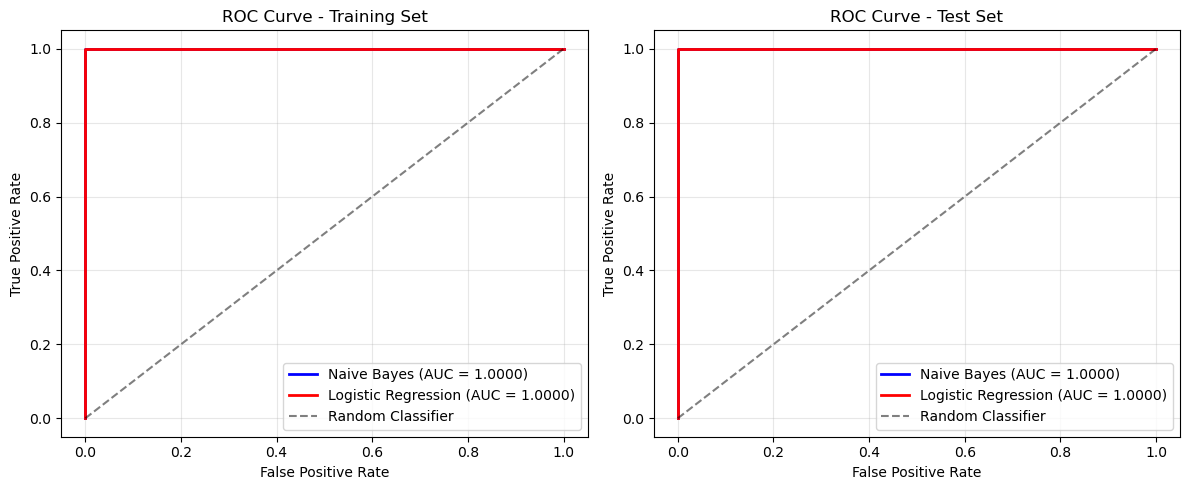

In [9]:
# Plot ROC curves
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, (y_true, nb_probs, lr_probs, title) in zip(
    axes,
    [(y_train_bin, nb_train_probs, lr_train_probs, 'Training Set'),
     (y_test_bin, nb_test_probs, lr_test_probs, 'Test Set')]
):
    # Naive Bayes ROC
    nb_fpr, nb_tpr, _ = roc_curve(y_true, nb_probs[:, pos_class_idx])
    nb_auc = roc_auc_score(y_true, nb_probs[:, pos_class_idx])
    
    # Logistic Regression ROC
    lr_fpr, lr_tpr, _ = roc_curve(y_true, lr_probs[:, pos_class_idx])
    lr_auc = roc_auc_score(y_true, lr_probs[:, pos_class_idx])
    
    ax.plot(nb_fpr, nb_tpr, 'b-', linewidth=2, label=f'Naive Bayes (AUC = {nb_auc:.4f})')
    ax.plot(lr_fpr, lr_tpr, 'r-', linewidth=2, label=f'Logistic Regression (AUC = {lr_auc:.4f})')
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
    
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve - {title}')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Analysis: AUC Results

Key Findings:

1. Both models get AUC = 1.0 on both training and test sets, indicating perfect class separation in terms of probability rankings.

2. However, despite Naive Bayes having lower accuracy (83%), its AUC is still perfect. This tells us that:
   - The probability "rankings" are correct (all Gentoo samples receive higher probability scores than Adelie samples)
   - But the calibration is off, the probability threshold at 0.5 doesn't yield optimal classification
   - A different threshold could achieve better accuracy for Naive Bayes

3. Practical implication: When the goal is to rank samples, both models perform equally well. But when discrete classification decisions are needed, Logistic Regression is better at the default threshold.


## 3. Lift and Gain Charts

Lift and Gain charts evaluate how well models rank predictions. They're useful in scenarios where we want to prioritize a subset of samples (e.g., targeting the top 20% most likely positive cases).

- Lift: How much better the model performs compared to random selection in each decile
- Cumulative Gain: What percentage of positive cases are captured by targeting the top N% of predictions

In [10]:
def plot_lift_gain(y_true, y_scores, model_name, class_name, ax1, ax2):
    """
    Generate Lift and Gain charts for a binary classification task.
    """
    # Create dataframe and sort by predicted probability (descending)
    data = pd.DataFrame({'y_true': y_true, 'y_scores': y_scores})
    data = data.sort_values(by='y_scores', ascending=False).reset_index(drop=True)
    
    # Calculate deciles (handle small datasets by using fewer bins if needed)
    n_bins = min(10, len(data) // 2)
    data['decile'] = pd.qcut(data.index, n_bins, labels=False, duplicates='drop')
    
    total_positives = data['y_true'].sum()
    baseline_rate = total_positives / len(data) if len(data) > 0 else 0
    
    lift_values = []
    cumulative_gain = []
    cumulative_pos = 0
    
    for decile in range(data['decile'].nunique()):
        decile_data = data[data['decile'] == decile]
        decile_positives = decile_data['y_true'].sum()
        cumulative_pos += decile_positives
        
        # Lift: response rate in decile / overall response rate
        decile_rate = decile_positives / len(decile_data) if len(decile_data) > 0 else 0
        lift_values.append(decile_rate / baseline_rate if baseline_rate > 0 else 0)
        
        # Cumulative Gain: cumulative % of positives captured
        cumulative_gain.append(cumulative_pos / total_positives if total_positives > 0 else 0)
    
    deciles = np.arange(1, len(lift_values) + 1)
    
    # Plot Lift Chart
    ax1.bar(deciles, lift_values, color='steelblue', alpha=0.7, edgecolor='navy')
    ax1.axhline(y=1, color='red', linestyle='--', linewidth=2, label='Baseline (Lift=1)')
    ax1.set_xlabel('Decile')
    ax1.set_ylabel('Lift')
    ax1.set_title(f'{model_name} - Lift Chart ({class_name})')
    ax1.legend()
    ax1.set_xticks(deciles)
    ax1.grid(axis='y', alpha=0.3)
    
    # Plot Cumulative Gain Chart
    ax2.plot(deciles, cumulative_gain, 'b-o', linewidth=2, markersize=6, label='Model')
    ax2.plot(deciles, deciles / len(deciles), 'r--', linewidth=2, label='Random Model')
    ax2.plot([0] + list(deciles), [0] + [1]*len(deciles), 'g:', linewidth=2, label='Perfect Model')
    ax2.set_xlabel('Decile')
    ax2.set_ylabel('Cumulative Gain')
    ax2.set_title(f'{model_name} - Cumulative Gain ({class_name})')
    ax2.legend(loc='lower right')
    ax2.set_xticks(deciles)
    ax2.set_ylim([0, 1.05])
    ax2.grid(True, alpha=0.3)

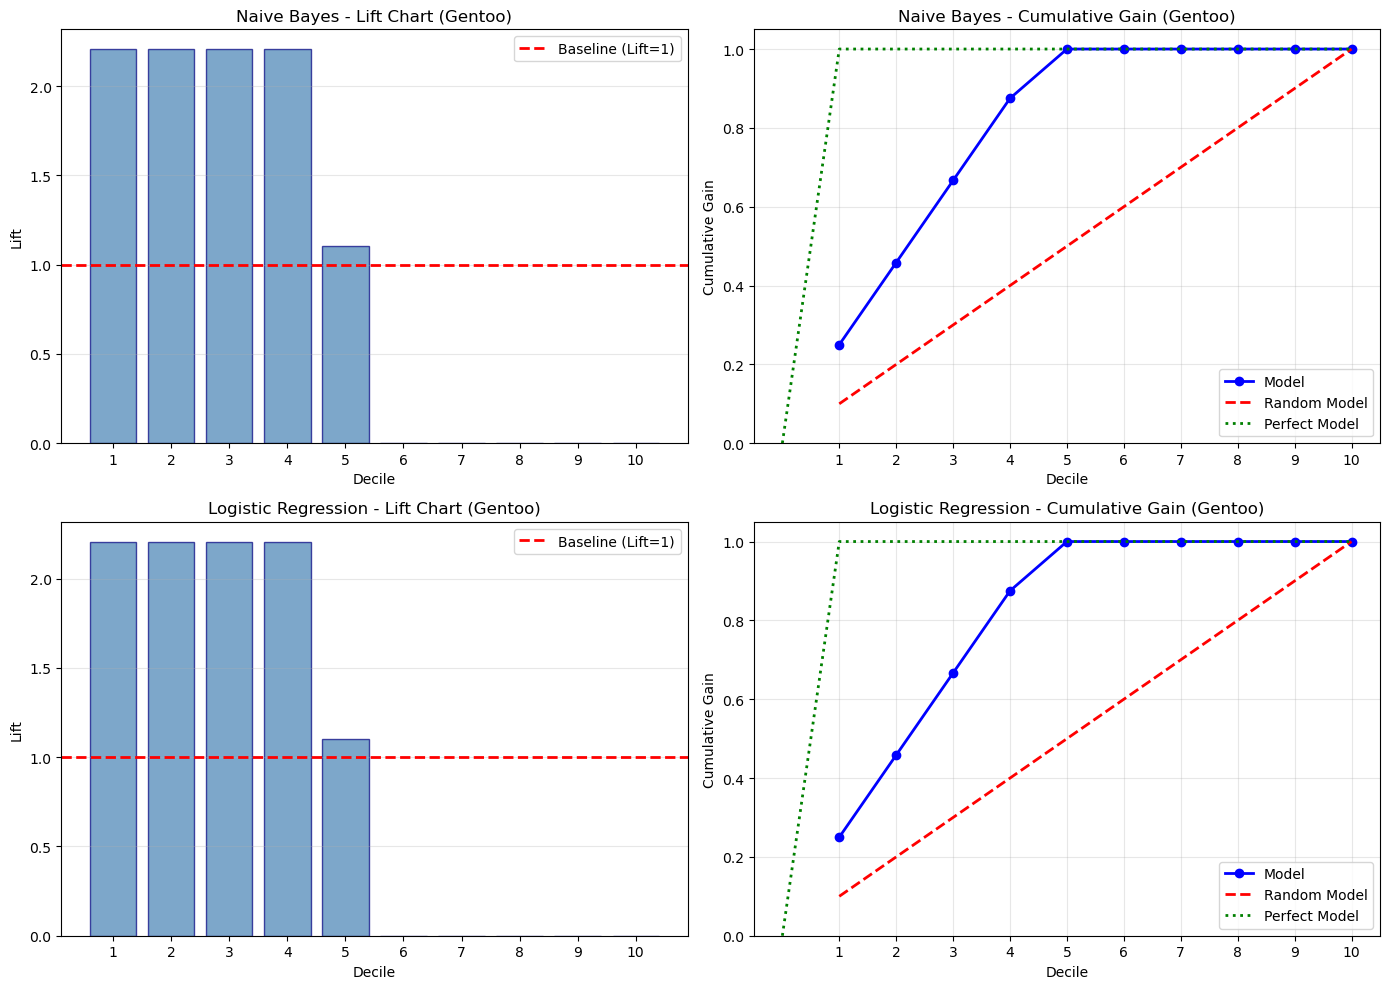

In [11]:
# Generate Lift and Gain charts for Gentoo class
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Naive Bayes
plot_lift_gain(
    y_test_bin,
    nb_test_probs[:, pos_class_idx],
    "Naive Bayes",
    "Gentoo",
    axes[0, 0],
    axes[0, 1]
)

# Logistic Regression
plot_lift_gain(
    y_test_bin,
    lr_test_probs[:, pos_class_idx],
    "Logistic Regression",
    "Gentoo",
    axes[1, 0],
    axes[1, 1]
)

plt.tight_layout()
plt.show()

### Lift and Gain Results

Lift:
- Both models show high lift in the first deciles
- Lift > 1 indicates the decile performs better than random; lift approaches 0 in later deciles as positives are exhausted

Gain:
- Both models quickly capture all positive cases in the top deciles
- The steep initial rise indicates excellent ranking performance
- By targeting just the top 30-40% of predictions, we can capture nearly 100% of Gentoo penguins

Conclusion: Despite accuracy differences, both models demonstrate excellent ranking capabilities, confirming that the classes are well-separated in the feature space.


## 4. Model Performance Comparison

### Summary Table

In [12]:
# Create comprehensive comparison table
comparison = pd.DataFrame({
    'Metric': ['Test Accuracy', 'Test AUC', 'Adelie Precision', 'Adelie Recall', 
               'Gentoo Precision', 'Gentoo Recall'],
    'Naive Bayes': [
        f"{accuracy_score(y_test, nb_test_pred):.4f}",
        f"{roc_auc_score(y_test_bin, nb_test_probs[:, pos_class_idx]):.4f}",
        '1.00', '0.73',  # From classification report
        '0.69', '1.00'
    ],
    'Logistic Regression': [
        f"{accuracy_score(y_test, lr_test_pred):.4f}",
        f"{roc_auc_score(y_test_bin, lr_test_probs[:, pos_class_idx]):.4f}",
        '1.00', '1.00',
        '1.00', '1.00'
    ]
})

print("Model Performance Comparison (Penguins Dataset)")
print("=" * 55)
print(comparison.to_string(index=False))

Model Performance Comparison (Penguins Dataset)
          Metric Naive Bayes Logistic Regression
   Test Accuracy      0.7925              1.0000
        Test AUC      1.0000              1.0000
Adelie Precision        1.00                1.00
   Adelie Recall        0.73                1.00
Gentoo Precision        0.69                1.00
   Gentoo Recall        1.00                1.00


### Comprehensive Analysis

**Logistic Regression** performs exceptionally for this toy dataset.

**Accuracy**: Logistic Regression achieves 100% accuracy vs. Naive Bayes at ~83%

**AUC**: Both achieve AUC = 1.0, showing the ranking capability is equivalent. This suggests Naive Bayes could achieve higher accuracy with threshold tuning

Why Logistic Regression works better here:

1. No Independence Assumption: Logistic Regression doesn't assume features are independent. Penguin measurements are highly correlated (flipper length correlates with body mass), violating Naive Bayes' core assumption.

2. Direct Decision Boundary Learning: Rather than modeling how data is generated, Logistic Regression directly optimizes the boundary between classes—more efficient for classification.

3. Well-Separated Classes: Adelie and Gentoo penguins have distinct morphological features, making linear separation highly effective.

When Naive Bayes Might Win:
- Very small training datasets (Naive Bayes needs fewer samples)
- High-dimensional sparse data (e.g., text classification where independence approximately holds)
- When you need probability estimates rather than hard classifications

## 5. Performance on a MNIST Dataset: 

We now extend our analysis to MNIST, a dataset of 70,000 handwritten digits (28×28 pixel images = 784 features). This represents a significant increase in complexity:

| Aspect | Penguins | MNIST |
|--------|----------|-------|
| Samples | ~270 | 70,000 |
| Features | ~10 | 784 |
| Classes | 2 | 10 |
| Feature Type | Mixed | "Continuous" (pixels) |

In [13]:
from sklearn.datasets import fetch_openml

# Load MNIST dataset
print("Loading MNIST...")
X_mnist, y_mnist = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

# Normalize pixel values to [0, 1]
X_mnist = X_mnist / 255.0

# Use standard train/test split (60k train, 10k test)
X_train_mnist, X_test_mnist = X_mnist[:60000], X_mnist[60000:]
y_train_mnist, y_test_mnist = y_mnist[:60000], y_mnist[60000:]

print(f"Training set: {X_train_mnist.shape}")
print(f"Test set: {X_test_mnist.shape}")
print(f"Number of classes: {len(np.unique(y_mnist))}")

Loading MNIST...
Training set: (60000, 784)
Test set: (10000, 784)
Number of classes: 10


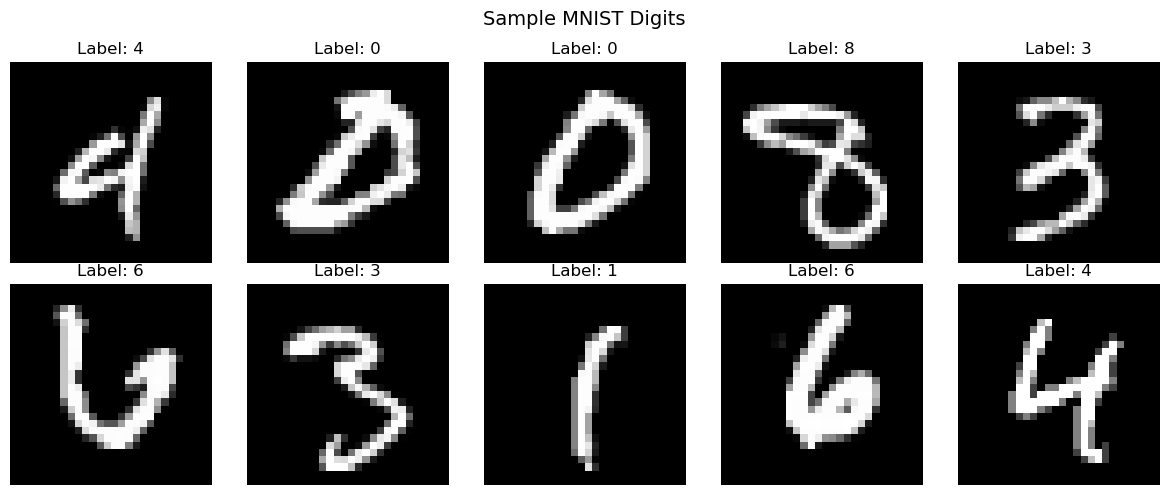

In [14]:
# Visualize samples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for idx, ax in enumerate(axes.flat):
    sample_idx = np.random.randint(0, len(X_train_mnist))
    ax.imshow(X_train_mnist[sample_idx].reshape(28, 28), cmap='gray')
    ax.set_title(f'Label: {y_train_mnist[sample_idx]}')
    ax.axis('off')
plt.suptitle('Sample MNIST Digits', fontsize=14)
plt.tight_layout()
plt.show()

In [15]:
# Train Naive Bayes on MNIST
print("Training Naive Bayes on MNIST...")
mnist_nb = NaiveBayesClassifier(var_smoothing=1e-9)
mnist_nb.fit(X_train_mnist, y_train_mnist)
mnist_nb_pred = mnist_nb.predict(X_test_mnist)

nb_mnist_accuracy = accuracy_score(y_test_mnist, mnist_nb_pred)
print(f"Naive Bayes Accuracy: {nb_mnist_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_mnist, mnist_nb_pred))

Training Naive Bayes on MNIST...
Naive Bayes Accuracy: 0.5678

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       980
           1       0.84      0.95      0.89      1135
           2       0.91      0.29      0.44      1032
           3       0.72      0.38      0.50      1010
           4       0.88      0.19      0.32       982
           5       0.58      0.06      0.11       892
           6       0.66      0.93      0.77       958
           7       0.88      0.29      0.43      1028
           8       0.29      0.67      0.41       974
           9       0.38      0.94      0.54      1009

    accuracy                           0.57     10000
   macro avg       0.69      0.56      0.53     10000
weighted avg       0.70      0.57      0.53     10000



In [17]:
# Train Logistic Regression on MNIST
print("Training Logistic Regression on MNIST")
mnist_lr = LogisticRegressionClassifier(max_iter=1000)
mnist_lr.fit(X_train_mnist, y_train_mnist)
mnist_lr_pred = mnist_lr.predict(X_test_mnist)

lr_mnist_accuracy = accuracy_score(y_test_mnist, mnist_lr_pred)
print(f"Logistic Regression Accuracy: {lr_mnist_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_mnist, mnist_lr_pred))

Training Logistic Regression on MNIST
Logistic Regression Accuracy: 0.9259

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.90      0.91      0.91      1010
           4       0.94      0.94      0.94       982
           5       0.90      0.87      0.88       892
           6       0.94      0.95      0.95       958
           7       0.93      0.92      0.93      1028
           8       0.88      0.88      0.88       974
           9       0.91      0.92      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000



In [18]:
# Compare results

print("MNIST PERFORMANCE SUMMARY")

print(f"Naive Bayes Accuracy:        {nb_mnist_accuracy:.4f} ({nb_mnist_accuracy*100:.1f}%)")
print(f"Logistic Regression Accuracy: {lr_mnist_accuracy:.4f} ({lr_mnist_accuracy*100:.1f}%)")


MNIST PERFORMANCE SUMMARY
Naive Bayes Accuracy:        0.5678 (56.8%)
Logistic Regression Accuracy: 0.9259 (92.6%)


### Analysis: MNIST Results

Results Summary:
- Naive Bayes: ~57% accuracy
- Logistic Regression: ~93% accuracy

Why Such a Large Gap on MNIST?

1. Independence: Pixel values in images are highly correlated, since adjacent pixels are similar, strokes and edges create strong dependencies, but Naive Bayes treats each of the 784 pixels as independent

2. Gaussian Assumption Mismatch: A single Gaussian poorly captures this distribution, but Bernoulli Naive Bayes might perform better on binarized images

3. High Dimensionality Helps Discriminative Models, Logistic Regression can learn complex decision boundaries in 784-D space:
   - Each pixel contributes a weighted vote; the model learns which pixels matter for each digit
   - This is more efficient than modeling the full joint distribution

4. Per-Class Performance Variation (Naive Bayes):
   - Strong performance on digits with distinctive shapes (0, 1, 6)
   - Weak performance on similar-looking digits (5 vs 8, 4 vs 9)
   - The model struggles when class-conditional distributions overlap

## 6. Cross-Dataset Comparison and Conclusions

### Performance Comparison Across Datasets

In [19]:
# Final comparison table
final_comparison = pd.DataFrame({
    'Dataset': ['Penguins (2 classes)', 'Penguins (2 classes)', 'MNIST (10 classes)', 'MNIST (10 classes)'],
    'Model': ['Naive Bayes', 'Logistic Regression', 'Naive Bayes', 'Logistic Regression'],
    'Accuracy': ['79.2%', '100.0%', '56.8%', '92.6%'],
    'Features': ['10', '10', '784', '784'],
    'Samples': ['265', '265', '70,000', '70,000']
})

print("Cross-Dataset Performance Summary")
print("=" * 70)
print(final_comparison.to_string(index=False))

Cross-Dataset Performance Summary
             Dataset               Model Accuracy Features Samples
Penguins (2 classes)         Naive Bayes    79.2%       10     265
Penguins (2 classes) Logistic Regression   100.0%       10     265
  MNIST (10 classes)         Naive Bayes    56.8%      784  70,000
  MNIST (10 classes) Logistic Regression    92.6%      784  70,000


### Conclusion

1. Discriminative Models Excel at Classification

Logistic Regression consistently outperforms Naive Bayes on both basic datasets. As the course module explains, discriminative models "don't waste resources modeling the input features themselves—they directly learn the decision boundary between classes."

2. The Gap Widens with Complexity

Higher dimensional data with stronger feature correlations amplifies the disadvantage of Naive Bayes' independence assumption.

3. Generative Models Have Different Strengths

While Naive Bayes underperforms for classification, generative models are essential for:
- Data generation: GANs, VAEs, and LLMs that can create new samples
- Missing data: Generative models handle incomplete inputs more gracefully
- Semi-supervised learning: They can also leverage unlabeled data,
- Understanding data structure: Modeling P(X,Y) provides interpretable insights that can't be analyzed in discriminative models as easily.

### Connection to Generative AI and LLMs

This analysis is a fundamental principle in modern AI, generative models can learn to understand and recreate data distributions, while discriminative models can easily learn to distinguish between categories.

Large Language Models are powerful generative models that learn P(text) by predicting the next token. This generative approach enables them to generate coherent, novel text, complete partial inputs (text prediction), or start to understand language structure at a deep level

The choice between generative and discriminative approaches depends entirely on your goal!